# Predict the Flip!

## Abstract

To many, the United States' 2020 Senate elections are the most important in recent times. Besides how divisive they are politically, these elections will be held during a global pandemic without precedence. For these reasons, I wanted to leverage data science processes to see if past elections could help predict current (or even future) ones.

This project explored whether or not a machine learning model can be used to predict how much of the vote a given candidate will receive. In order to do so, I needed to create my own dataset directly from Wikipedia before using a random forest regressor from Scikit-Learn to get my results. The best model was able to achieve a RMSE of 10.86% and provide a number of insights about what is important for a candidate to get more votes.

Currently, the components of this project can be applied to benefit political parties, candidates, students, and/or educators in political or data science fields.

## Problem and Plan

Now that the data has been collected and organized, I need to prepare it for modeling and begin the exploration process.

The model created here will be the *first* step of many to complete my overall goal of being able to predict state-by-state in order to create an aggregate picture of the nation's senate elections. However, before that, I needed to confirm it is even possible on a basic level. 

I plan to use the `RandomForestRegressor` from Scikit-Learn because it will allow me to easily collect the feature importances as a value, but I will evaluate the performance of a few others as well. This first model will will attempt to answer the question:

> **_Can I predict the winner of a U.S. Senate general election with a dataset scraped from information available on Wikipedia?_**

## Links

During the data collection process there were a few websites that inspired or helped to create this dataset. The Wikipedia page used to create the dataset is: [List of U.S. Senate Elections](https://en.wikipedia.org/wiki/List_of_United_States_Senate_elections)

The other links are:

* [Link to BallotPedia](https://ballotpedia.org/Legislative_Branch) (Original inspiration for project)


* [Link to Harvard Dataverse](https://dataverse.harvard.edu/dataverse/medsl_senate) (Inspiration for the structure of the dataset)


* [Link to Brookings](https://www.brookings.edu/multi-chapter-report/vital-statistics-on-congress/) (Inspiration for features, potential integration later)


* [Link to Wiki-Category (U.S. Senator)](https://commons.wikimedia.org/wiki/Category:Senators_of_the_United_States) (Inspiration for features, potential integration later)

## Imports

In [1]:
import requests
import regex
import pickle
import tzlocal

import functions as dlf ## custom function package in repo as 'functions.py'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xgboost as xgb
import sklearn.metrics as metrics

from importlib import reload
from bs4 import BeautifulSoup
from genderize import Genderize
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
# from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')
%matplotlib inline

## Loading data

In [2]:
## Reading in data + version control for EDA/modeling + Quick Check (Q.C.)
df = pd.read_csv('Senate_generals_thru_2016.csv')
df_eda = df.copy()
df_model_test = df.copy()
display(df.tail())

## Separate df with gender estimates
df_gend = pd.read_csv('df_gend.csv')

,%,Turnout,Incumb_Y,State,Cln_name,Year,Terms_in_office,Party_enc,First_name,Seats_up%,Seats_before%
5583,1.01,320467.0,0,Vermont,Peter Diamondstone,2016,0,T,Peter,0.000000,0.00
5584,59.01,3243317.0,1,Washington,Patty Murray,2016,4,D,Patty,0.227273,0.44
5585,40.99,3243317.0,0,Washington,Chris Vance,2016,0,R,Chris,0.444444,0.54
5586,50.20,2947345.0,1,Wisconsin,Ron Johnson,2016,1,R,Ron,0.444444,0.54
5587,46.80,2947345.0,0,Wisconsin,Russ Feingold,2016,0,D,Russ,0.227273,0.44


## EDA

In [3]:
## Fill NAs left from cleaning
df_eda.dropna(inplace=True)

## Fixing State regex missed cases
df_eda.at[1461, 'State'] = 'West_Virginia'
df_eda.at[1632, 'State'] = 'Nevada'

## Quick Check (Q.C.)
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5583 entries, 0 to 5587
Data columns (total 11 columns):
%                  5583 non-null float64
Turnout            5583 non-null float64
Incumb_Y           5583 non-null int64
State              5583 non-null object
Cln_name           5583 non-null object
Year               5583 non-null int64
Terms_in_office    5583 non-null int64
Party_enc          5583 non-null object
First_name         5583 non-null object
Seats_up%          5583 non-null float64
Seats_before%      5583 non-null float64
dtypes: float64(4), int64(3), object(4)
memory usage: 683.4+ KB


### Turnout by Year

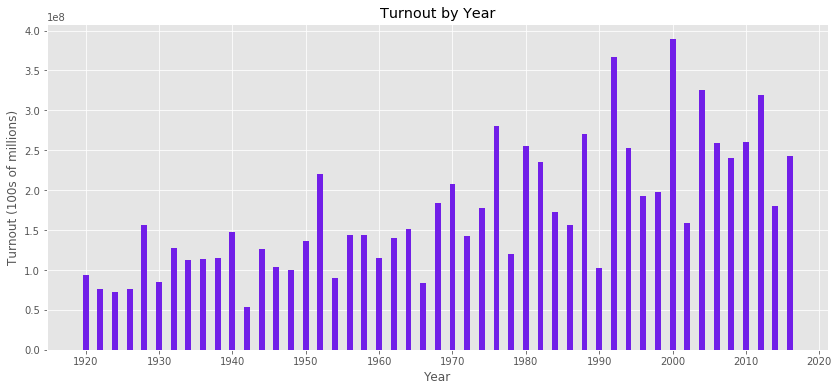

In [4]:
## Setting figsize
fig, ax = plt.subplots(figsize=(14,6))

## Groupby Year then summing turnout
turnout_by_yr = df_eda.groupby('Year')['Turnout'].sum()

## Plotting + formatting
ax.bar(turnout_by_yr.index, turnout_by_yr, color='#711EE8')
ax.set_xticks(np.linspace(1920, 2020, 11))
ax.set(title='Turnout by Year', xlabel='Year', ylabel='Turnout (100s of millions)');

> It is apparent that turnout has (on average) been increasing ever since there has been elections.

This could be due to many reasons, such as increases in population and/or literacy. Besides the gradual increase, it is clear that every decade (starting 1940) seems to have one cycle where turnout falls to about or below 150 million votes. This becomes more apparent post 1970, where turnout is mostly around 200 million, making it look even sharper of a drop.

### Average Term Length by State

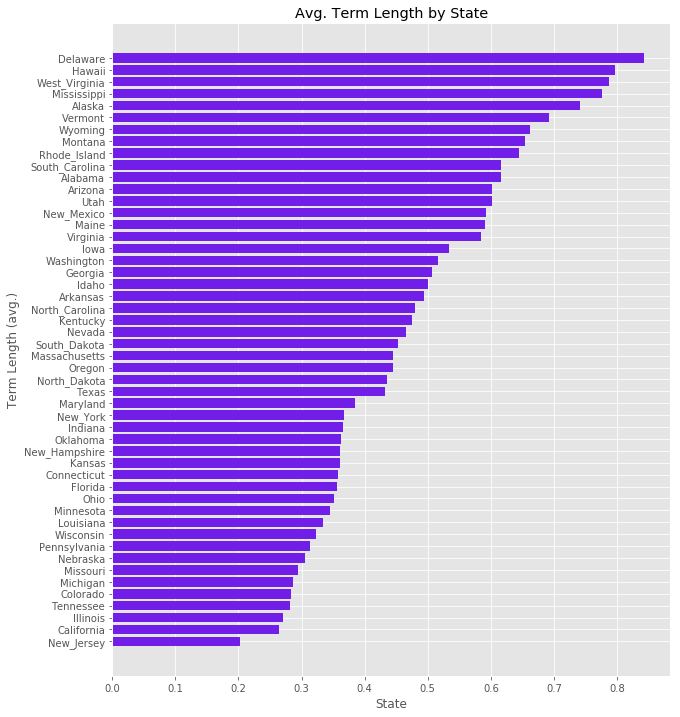

In [5]:
## Setting figsize
fig, ax = plt.subplots(figsize=(10,12))

## Groupby State then average term length
terms_by_state = df_eda.groupby('State')['Terms_in_office'].mean()

## Plotting + formatting
ax.barh(terms_by_state.sort_values().index, terms_by_state.sort_values(), color='#711EE8')
ax.set(title='Avg. Term Length by State', xlabel='State', ylabel='Term Length (avg.)');

> It is clear that some states tend to keep incumbent senators for longer (on average).

To my surprise, there are large differences between states in this category. In order to interpret these values, one must understand that a value will go up if this state has elections where:
 * There is a senator with 1+ terms involved (more the better)
 * There are not a lot of competitors, or the candidate runs unopposed.
 
Given this, its easy to see that a state like Delaware tends to keep it's senator around once they are in office and likely do not have much competition or a homogeneous political environment. On the other hand, a state like New Jersey must be highly contested and thus tend to cycle through senators. 

### Number of Terms by First Name

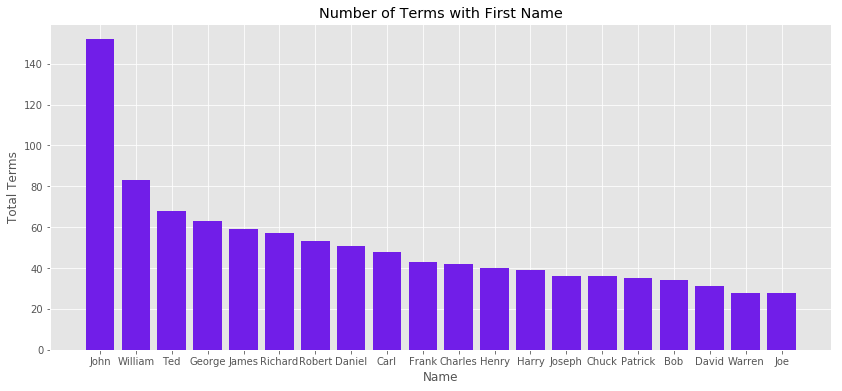

In [6]:
## Setting figsize
fig, ax = plt.subplots(figsize=(14,6))

## Groupby first name + summing of terms
terms_by_firstname = df_eda.groupby('First_name')['Terms_in_office'].sum()
firstname_top20 = terms_by_firstname[terms_by_firstname > 0].sort_values(ascending=False).head(20)

## Plotting + formatting
ax.bar(firstname_top20.index, firstname_top20, color='#711EE8')
ax.set(title='Number of Terms with First Name', xlabel='Name', ylabel='Total Terms');

> 'John' is *by far* the most common first name among U.S. Senators.

Unsurprisingly, the top 20 did not include any traditional female names. Of these top 20, they are the traditional American white male names generally associated with the Bible or Judeo-Christian religions. The first woman's name is Barbara and does not appear until the 34th rank with 16 total terms. I would like to look into using name frequency as a potential feature later on.

### Number of Candidates Per Party by Year

#### Part 1

In [7]:
## Helper list for 'for' loop + results container
party_enc_list = ['D', 'R', 'I', 'S', 'T']
party_series_dict = {}

## Looping through helper list to slice df by ea. party
for party in party_enc_list:
    ## Groupby year + count of candidates + storage in results container
    if party == 'D':
        dems_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = dems_by_year
    elif party == 'R':
        repubs_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = repubs_by_year
    elif party == 'I':
        indeps_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = indeps_by_year
    elif party == 'S':
        socls_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = socls_by_year
    elif party == 'T':
        thirds_by_year = df_eda[df_eda['Party_enc'] == party].groupby('Year')['Cln_name'].count()
        party_series_dict[party] = thirds_by_year

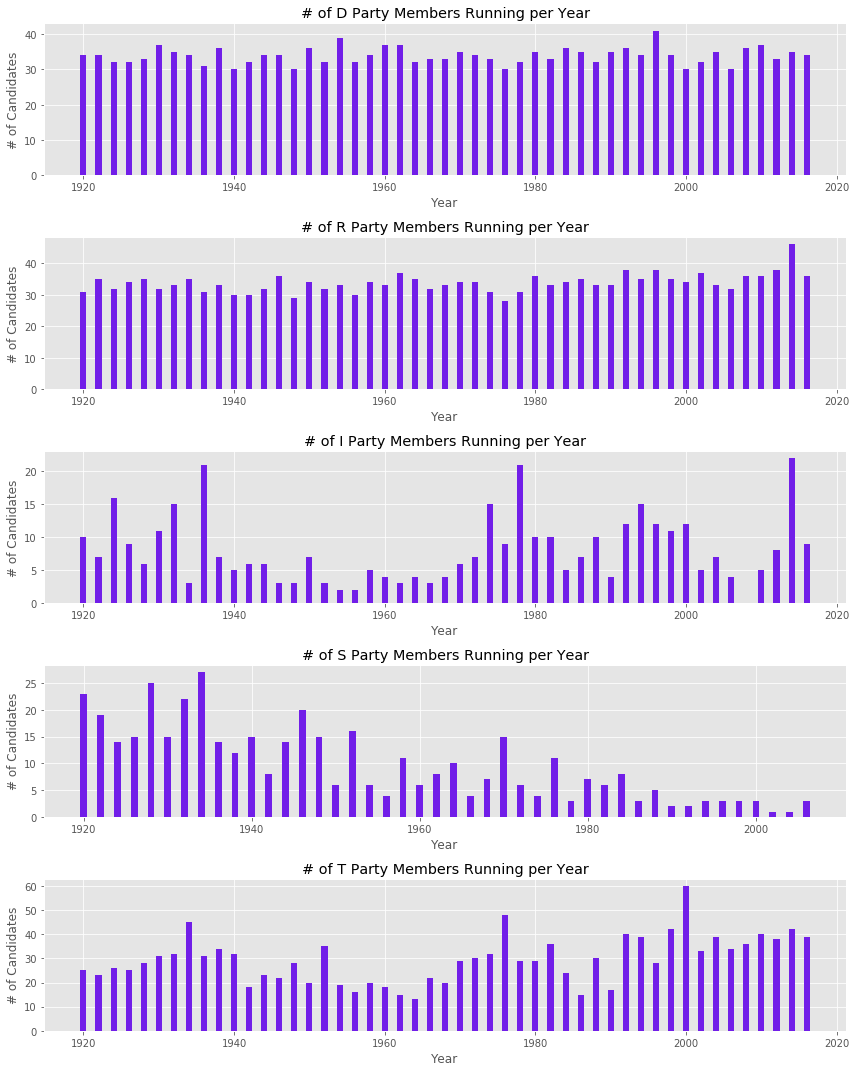

In [8]:
## Setting figsize + subplots structure + flatten ax for iteration
fig, ax = plt.subplots(figsize=(12,15), nrows=5)
axes = ax.flatten()

## Plotting ea. groupby stored in results dict
for i, party in enumerate(party_series_dict):
    series = party_series_dict[party]
    axes[i].bar(series.index, series, color='#711EE8')
    axes[i].set(title=f'# of {party} Party Members Running per Year', xlabel='Year', ylabel='# of Candidates')
    plt.tight_layout();

> It is clear to see that Democrats and Republicans have enjoyed a steady presence in elections ever since the beginning.

The Independents' presence has wax and waned over time, but also do not have unified party leadership, pointing towards national or state conditions driving this trend.

Given recent history, it is not surprising to see that declared Socialist candidates have been declining in participation over time. The last instance of one in a general election was 2006. 

In this dataset, Third Party candidates represent whomever does not declare into any of the other listed parties. Given this it is hard to be specific, but it easy to spot clear dips and spikes in their presence (2000 had 60 Third Party candidates).

#### Part 2

> In order to make this information easier to digest, I decided to combine the previous subplots into one with each of the parties' participation in that years election. In order to allow for ease of viewing I broke this plot into decade-long chunks. 

> In addition for brevity, the code for this is in the 'functions.py' file in this repository.

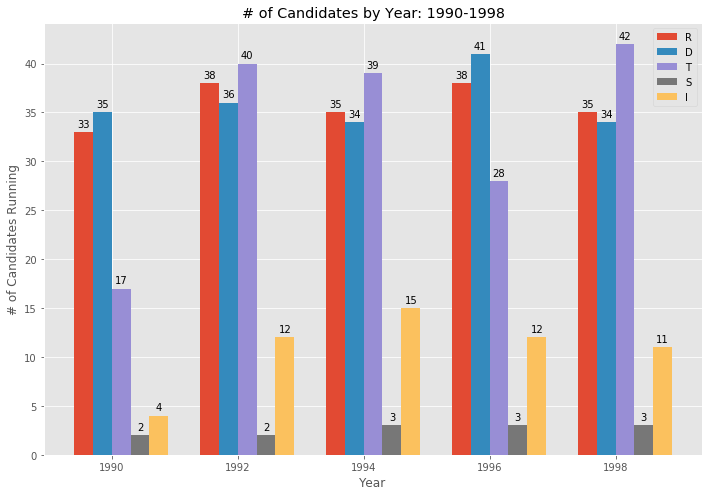

In [9]:
## 1990's elections
dlf.cand_per_yr_viewer(party_series_dict, '1990', '1998')

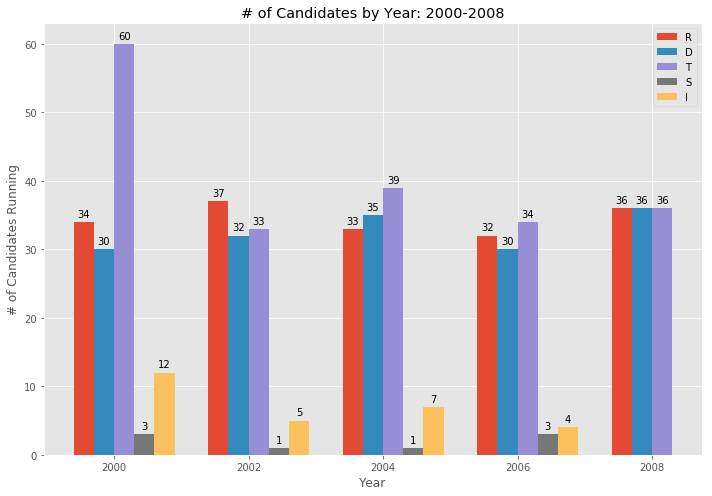

In [10]:
## 2000's elections
dlf.cand_per_yr_viewer(party_series_dict, '2000', '2008')

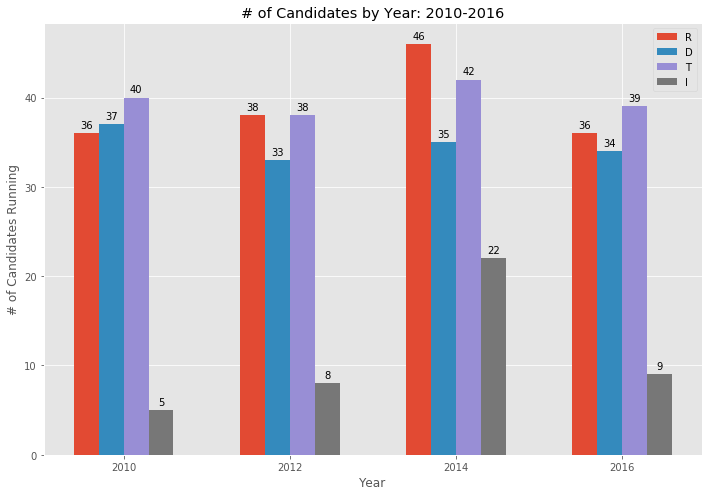

In [11]:
## 2010's elections (last year 2016)
dlf.cand_per_yr_viewer(party_series_dict, '2010', '2016')

> Being able to compare side by side, its easy to see how the Democrats and Republicans tend to keep within 5 candidates of each other while (unless you aggregate them) no other comes close.

### Percentage of Vote per Party by Incumbency

In [12]:
## Helper list for 'for' loop + results container
party_enc_list = ['D', 'R', 'I', 'S', 'T']
party_incumb_series_dict = {}

## Looping through helper list to slice df by ea. party
for party in party_enc_list:
    ## Groupby incumbency + average of vote %s + storage in results container
    if party == 'D':
        dems_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = dems_by_year2
    elif party == 'R':
        repubs_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = repubs_by_year2
    elif party == 'I':
        indeps_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = indeps_by_year2
    elif party == 'S':
        socls_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = socls_by_year2
    elif party == 'T':
        thirds_by_year2 = df_eda[df_eda['Party_enc'] == party].groupby('Incumb_Y')['%'].mean()
        party_incumb_series_dict[party] = thirds_by_year2

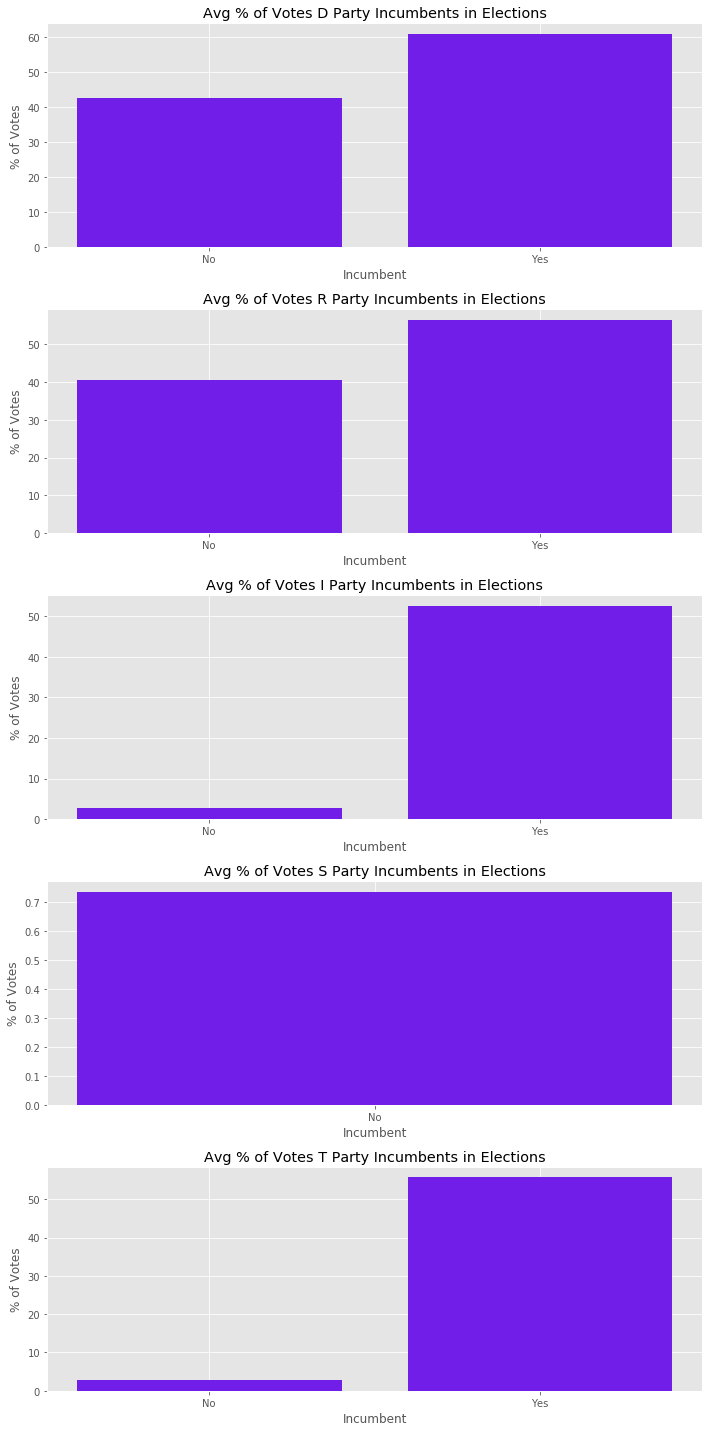

In [13]:
## Setting figsize + subplots structure + flatten ax for iteration
fig, ax = plt.subplots(figsize=(10,20), nrows=5)
axes = ax.flatten()

## Looping through ea. party in results dict
for i, party in enumerate(party_incumb_series_dict):
    series = party_incumb_series_dict[party].copy()
    ## Try/Except plotting + formatting ('S' party never had incumbent)
    try:
        series.set_axis(['No', 'Yes'], inplace=True)
        axes[i].bar(series.index, series, color='#711EE8')
        axes[i].set(title=f'Avg % of Votes {party} Party Incumbents in Elections', xlabel='Incumbent', ylabel='% of Votes')
        axes[i].set(xticks=['No', 'Yes'])
    except ValueError:
        series.set_axis(['No'], inplace=True)
        axes[i].bar(series.index, series, color='#711EE8')
        axes[i].set(title=f'Avg % of Votes {party} Party Incumbents in Elections', xlabel='Incumbent', ylabel='% of Votes')
        axes[i].set(xticks='No')
        

    plt.tight_layout();

> Being an incumbent senator is *very important* to indicating the amount of votes one will receive in the following election. 

This matters the least if you are in the Democratic or Republican parties. The difference in vote percentage in these two parties is about 15-20% while the others show ~50% (if they have even had an incumbent). 

## Prep for model

In [14]:
## Encoding year to help account for future values origin year = 2020
df_model_test['Year_enc'] = df_model_test['Year'].map(lambda x: x-2020)

## Drop name refs
df_model_test.drop(columns=['Cln_name', 'First_name', 'Year'], inplace=True)

## Fill NAs left from cleaning
df_model_test.dropna(inplace=True)

## Fixing State regex missed cases
df_model_test.at[1461, 'State'] = 'West_Virginia'
df_model_test.at[1632, 'State'] = 'Nevada'

## Setting variables + Q.C.
y = df_model_test.pop('%')
X = df_model_test.copy()
display(y.head())
display(X.head())
display(X.info())

## drop_first assumes that State = Alabama and Party = D
X_ohe = pd.get_dummies(X, drop_first=True)
display(X_ohe.columns)

## TT split
X_train, X_test, y_train, y_test = train_test_split(X_ohe, y, random_state=222)

0    66.10
1    33.05
2     0.85
3    69.27
4    29.51
Name: %, dtype: float64

,Turnout,Incumb_Y,State,Terms_in_office,Party_enc,Seats_up%,Seats_before%,Year_enc
0,233985.0,1,Alabama,1,D,0.361702,0.489583,-100
1,233985.0,0,Alabama,0,R,0.306122,0.510417,-100
2,233985.0,0,Alabama,0,S,0.000000,0.000000,-100
3,231960.0,0,Alabama,0,D,0.361702,0.489583,-100
4,231960.0,0,Alabama,0,R,0.306122,0.510417,-100


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5583 entries, 0 to 5587
Data columns (total 8 columns):
Turnout            5583 non-null float64
Incumb_Y           5583 non-null int64
State              5583 non-null object
Terms_in_office    5583 non-null int64
Party_enc          5583 non-null object
Seats_up%          5583 non-null float64
Seats_before%      5583 non-null float64
Year_enc           5583 non-null int64
dtypes: float64(3), int64(3), object(2)
memory usage: 392.6+ KB


None

Index(['Turnout', 'Incumb_Y', 'Terms_in_office', 'Seats_up%', 'Seats_before%',
       'Year_enc', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_Florida', 'State_Georgia', 'State_Hawaii',
       'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa',
       'State_Kansas', 'State_Kentucky', 'State_Louisiana', 'State_Maine',
       'State_Maryland', 'State_Massachusetts', 'State_Michigan',
       'State_Minnesota', 'State_Mississippi', 'State_Missouri',
       'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'St

## Modelling

### Model Selection

#### Vanilla Models

In [15]:
## Instantiating a bunch of classifiers to test
tree_reg = DecisionTreeRegressor()
rf_reg = RandomForestRegressor(n_jobs=-1)
knn_reg = KNeighborsRegressor(n_jobs=-1)
ada_reg = AdaBoostRegressor()
grad_reg = GradientBoostingRegressor()
xgb_reg = xgb.XGBRegressor(n_jobs=-1)

## Helper list to create eval. table
reg_list = [tree_reg, rf_reg, knn_reg, ada_reg, grad_reg, xgb_reg]

In [16]:
## See 'functions.py' for code; Creating vanilla model eval. table choose final model
vanilla_metrics_df = dlf.regressor_tester(reg_list, X_train, X_test, y_train, y_test, display_res=True)

------------------------------ 6 regressors evaluated. ------------------------------


,Name,Tr_MSE,Tr_RMSE,Tr_R2,Te_MSE,Te_RMSE,Te_R2
0,<class 'sklearn.tree._classes.DecisionTreeRegr...,10.350590,3.217233,0.984986,163.875442,12.801384,0.762768
1,<class 'sklearn.ensemble._forest.RandomForestR...,23.015343,4.797431,0.966615,119.623981,10.937275,0.826828
2,<class 'sklearn.neighbors._regression.KNeighbo...,491.824868,22.177125,0.286584,746.882478,27.329151,-0.081215
3,<class 'sklearn.ensemble._weight_boosting.AdaB...,182.787101,13.519878,0.734858,200.243114,14.150728,0.710121
4,<class 'sklearn.ensemble._gb.GradientBoostingR...,99.063553,9.953068,0.856303,129.301825,11.371096,0.812818
5,<class 'xgboost.sklearn.XGBRegressor'>,101.361315,10.067836,0.852970,129.382346,11.374636,0.812701


> Given these results I am going to try tuning the `RandomForestRegressor` and the `XGBRegressor` since they demonstrated the lowest testing RMSE.

#### GridSearchCV Prep

I wanted my GridSearchCV to be able to optimize R-squared if necessary. In order to do so, one must create their own scoring function. This code was heavily inspired by code found [here](https://stats.stackexchange.com/questions/110599/how-to-get-both-mse-and-r2-from-a-sklearn-gridsearchcv).

In [17]:
## Scoring functions
def rsqd_scorer(y_true, y_pred):
    from sklearn.metrics import r2_score
    
    score = r2_score(y_true, y_pred)
    
    return score

def rmse_scorer(y_true, y_pred):
    from sklearn.metrics import mean_squared_error
    import numpy as np
    
    score = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return score

def rmse_r2_scorer(y_true, y_pred):
    
    score = rmse_scorer(y_true, y_pred)
    rsqd_scorer(y_true, y_pred)
    
    return score

def two_scores(grtr_is_bttr=False):
    from sklearn.metrics import make_scorer
    
    return make_scorer(rmse_r2_scorer, greater_is_better=grtr_is_bttr)

#### Random Forest Regressor

> Each of these cells show previous results from some of the searches along with the parameters used for them. The results are in the cells in the format:`[mean_train_score]/[mean_test_score]` 

In [19]:
## Setting params
params = {'n_jobs': [-1],
          'criterion': ['mse', 'mae'],
          'max_depth': [10],
          'n_estimators': [100, 200],
          'min_samples_leaf': [1, 2]}

## Custom grid search function with display of results; code in 'functions.py'
test_grid = dlf.grid_searcher(rf_reg, params, X_train, X_test, y_train, y_test, cv=3, custom_scorer=dlf.two_scores())

## Additional Q.C.
display(test_grid.best_score_)
display(test_grid.best_estimator_.score(X_test, y_test))
test_grid.best_estimator_.score(X_train, y_train)

---- Timer started at: 08/27/2020 - 12:56 PM ----
---- Timer stopped at: 08/27/2020 - 01:00 PM ----
---- Time elasped: 0:04:05.628870 ----
Mean Training Score: -8.4
Mean Test Score: -1.1e+01
Best Parameters:
{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1}


-10.610419420249615

0.8221583663116367

0.8931121273387673

In [ ]:
#-764.44/-1110.01
# params = {'n_jobs': [-1],
#           'criterion': ['mae', 'mse'],
#           'max_depth': [5, 10, 20, 40, 70, 100, None],
#           'n_estimators': [10, 50, 100],
#           'min_samples_leaf': [1, 2, 5]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

In [ ]:
#-7.4/-11.0
# params = {'n_jobs': [-1],
#           'criterion': ['mse'],
#           'max_depth': [5, 10, 20, 40, 70, 100, None],
#           'n_estimators': [10, 50, 100],
#           'min_samples_leaf': [1, 2, 5]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

In [ ]:
#-5.5/-11.0
# params = {'n_jobs': [-1],
#           'criterion': ['mse'],
#           'max_depth': [20, 30, 40, None],
#           'n_estimators': [80, 100, 120, 140],
#           'min_samples_leaf': [1, 2]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

In [ ]:
#-6.5/-11.0
# params = {'n_jobs': [-1],
#           'criterion': ['mse'],
#           'max_depth': [10, 15, 20, None],
#           'n_estimators': [140, 160, 180, 200, 250, 300],
#           'min_samples_leaf': [1, 2]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

In [ ]:
#-9.0/-11.0
# params = {'n_jobs': [-1],
#           'criterion': ['mse'],
#           'max_depth': [3, 5, 10, None],
#           'n_estimators': [200, 210, 220, 250],
#           'min_samples_leaf': [2]}
# display(test_grid.best_score_)
# display(test_grid.best_params_)

#### XGBoost Regressor

> Each of these cells show previous results from some of the searches along with the parameters used for them. The results are in the cells in the format:`[mean_train_score]/[mean_test_score]` 

Originally I ran a grid search on the `XGBoostRegressor` optimizing R-squared, which did not improve or change upon the results from the `RandomForestRegressor`. This code is commented out to reduce notebook run time, but is still viable.

In [ ]:
# ## GridSearch for XGB
# params2 = {'n_jobs': [-1],
#           'learning_rate': [0.1],
#           'max_depth': [5, 7],
#           'n_estimators': [50],
#           'min_child_weight': [5]}

# test_grid2 = dlf.grid_searcher(xgb_reg, params2, X_train, X_test, y_train, y_test, cv=3, custom_scorer=two_scores())

# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# test_grid2.best_estimator_.score(X_train, y_train)

In [ ]:
# ## tr=68.96 te=81.84
# display(test_grid2.best_params_)
# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# display(test_grid2.best_estimator_.score(X_train, y_train))

In [ ]:
# ## tr=91.35 te=82.27
# display(test_grid2.best_params_)
# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# display(test_grid2.best_estimator_.score(X_train, y_train))

In [ ]:
# ## tr=89.33 te=81.92
# display(test_grid2.best_params_)
# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# display(test_grid2.best_estimator_.score(X_train, y_train))

In [ ]:
# ## tr=88.97 te=82.27
# display(test_grid2.best_params_)
# display(test_grid2.best_score_)
# display(test_grid2.best_estimator_.score(X_test, y_test))
# display(test_grid2.best_estimator_.score(X_train, y_train))

### Final Model

> Both `RandomForestRegressor()` and `XGBRegressor()` performed similarly during the vanilla run and testing/tuning. It turns out the the standard parameters work the best for now. I am choosing to go with the Random Forest for my final model, but either should be fine for future usage.

In [18]:
## Instantiation + setting of params
rf_reg_final = RandomForestRegressor(max_depth=20, n_estimators=200, min_samples_leaf=1, n_jobs=-1, random_state=24)

## Custom function to fit, pred, and display results; code in 'functions.py'
rf_fin_res_df, y_hat_train, y_hat_test = dlf.regressor_tester(rf_reg_final, X_train, X_test, y_train, y_test, display_res=True, keep_preds=True)

## Creating residuals for model evaluation
y_train_resids = y_hat_train - y_train
y_test_resids = y_hat_test - y_test

,Name,Tr_MSE,Tr_RMSE,Tr_R2,Te_MSE,Te_RMSE,Te_R2
0,<class 'sklearn.ensemble._forest.RandomForestR...,30.774839,5.547507,0.95536,118.012349,10.863349,0.829161


### Results

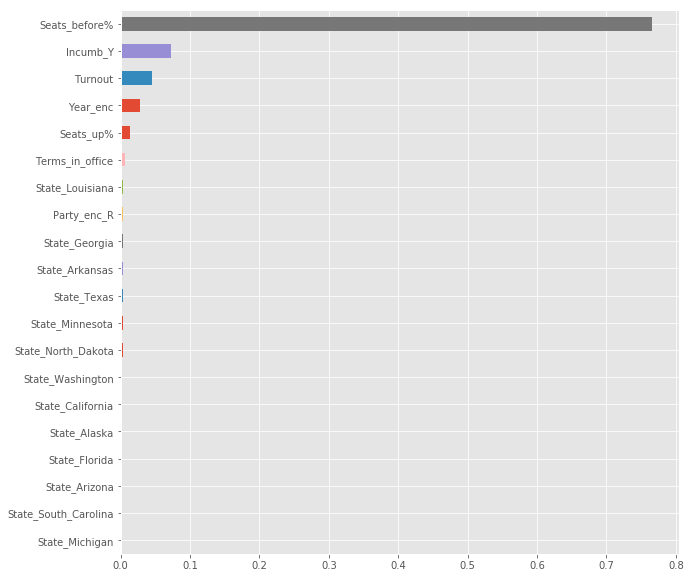

In [19]:
## Plotting feature importances pt. 1
imps_ = dlf.plot_importance(rf_reg_final, X_train, top_n=20)

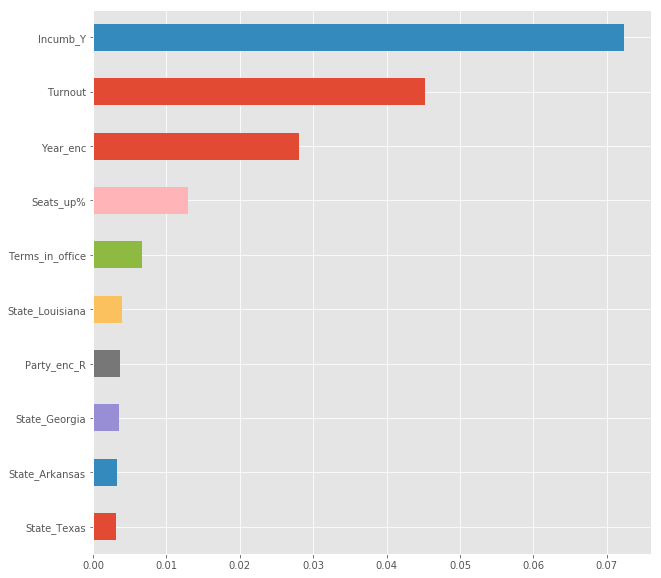

In [20]:
## Plotting feature importances pt. 2
imps_.drop(index='Seats_before%').sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(10,10));

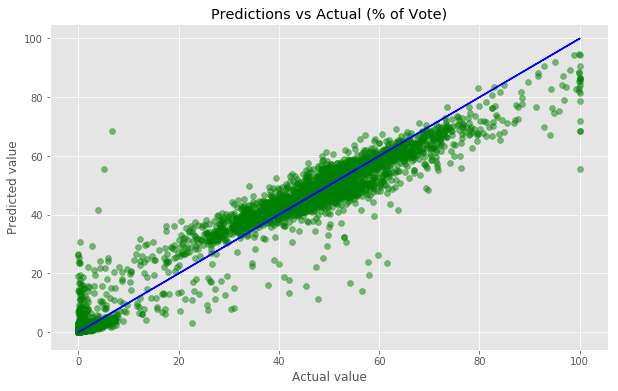

In [21]:
## Setting figsize
fig, ax = plt.subplots(figsize=(10,6))

## Plotting + formatting
ax.plot(y_train, y_train, c='b')
ax.set(title='Predictions vs Actual (% of Vote)', xlabel='Actual value', ylabel='Predicted value')
ax.scatter(y_train, y_hat_train, c='g', alpha=0.5);

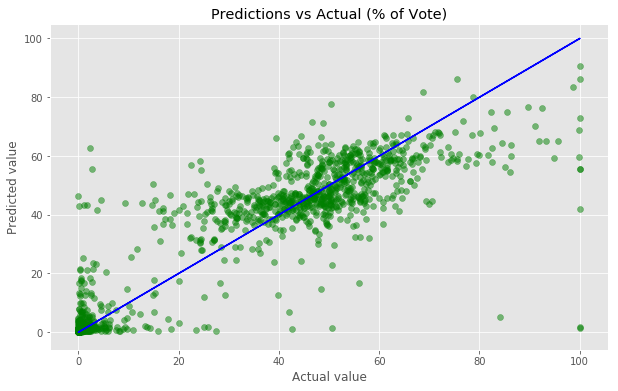

In [22]:
## Setting figsize
fig, ax = plt.subplots(figsize=(10,6))

## Plotting + formatting
ax.plot(y_test, y_test, c='b')
ax.set(title='Predictions vs Actual (% of Vote)', xlabel='Actual value', ylabel='Predicted value')
ax.scatter(y_test, y_hat_test, c='g', alpha=0.5);

## Gender stuff

One of the features I wanted to consider for this dataset is gender. However, in order to guarantee accuracy, I would need to find someplace to scrape this information. Luckily, there is an API available for use to estimate the likelihood of a name being Male, Female, or None based upon their database. 

For these reasons, I wanted to train two different models on the same dataset; one with and one without gender as a feature. 

### Data Prep

#### Cleaning

In [23]:
## Function usage to add on genders 1000 at a time
# df_gend = gender_guesser(df_gend, online=True)

In [24]:
## Verison control + Q.C.
df_model_gend = df_gend.copy()
display(df_model_gend.info())
df_model_gend['Gender'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5588 entries, 0 to 5587
Data columns (total 12 columns):
%                  5588 non-null float64
Turnout            5583 non-null float64
Incumb_Y           5588 non-null int64
State              5588 non-null object
Cln_name           5588 non-null object
Year               5588 non-null int64
Terms_in_office    5588 non-null int64
Party_enc          5588 non-null object
First_name         5588 non-null object
Seats_up%          5588 non-null float64
Seats_before%      5588 non-null float64
Gender             5428 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 524.0+ KB


None

M    4921
F     507
Name: Gender, dtype: int64

In [25]:
## Helper list for male names misclassified
holder_m = ['James Eli Watson', 'Selden Spencer', 'Forsman', 'Trudell', 
          'Robert La Follette', 'Cherry', 'France', 'Eickelberg', 
          'Day', 'Kindler', 'Carey', 'Duly McCone', 'Huey Long', 'Lanier', 
          'Glen Corkery', 'Starr', 'Hager', 'Verhei', 'Happy Chandler', 
          'Philo Farnsworth', 'Ona Searles', 'Lewis Haley Tiley', 'Cecil Creel',
          'John Marion Morris', 'Lynn Frazier', 'Glen Taylor', 'Hanna',
          'Lynn Stumbaugh', 'Alexis DuPont Bayard', 'Arthur Vivian Watkins',
          'Val Bjornson', 'Laurence Pickett', 'Lou Welch', 'John Little McClellan',
          'Cecil Underwood', 'Melvin Babcock Morgan', 'Cecil Heftel', 'Cecil Pitard',
          'Laurence Burton', 'Lynn Henderson', 'Lorin Oxley', 'Chic Hecht',
          'Arlyn Wollenburg', 'Lou Gold', 'Mel Logan', 'Lindsey Graham',
          'Lamar Alexander', 'John Neely Kennedy', 'Maclyn Stringer', 'Cam Cavasso',
          'LeAlan Jones', 'Rand Paul', 'Tracy Potter', 'David Lory VanDerBeek',
          'Paul Lindsey Sadler']

## Helper list for non-specific names misclassified
holder_n = ['Miscellaneous', 'Others', 'Write-In Candidates']

## Helper list for items missed during initial cleaning
holder_c = ['Lawrence Gilfedder,Candidate for Governor in 1948. Ran for Governor in 1952 and 1954. Ran for Senate in 1958, 1960, 1962, 1964, 1966, and 1970.',
            'Jerry Zeldin, Laurel Springs', 'Howard Cannon, City Attorney of Las Vegas',
            'Douglas McKay,former Governor of Oregon  and United States Secretary of the Interior',
            'Efia Nwangaza*']

## Looping through each name in df, matching to helper lists, editing on the way
for i, name in zip(df_model_gend.index, df_model_gend['Cln_name']):
    ## Fixing male names
    for target in holder_m:
        if name == target:
            df_model_gend.at[i, 'Gender'] = 'M'
    ## Fixing non-specific names
    for target in holder_n:
        if name == target:
            df_model_gend.at[i, 'Gender'] = 'None'
    ## Fixing ea. case of cleaning respectively        
    if name == holder_c[0]:
        n_name = 'Lawrence Gilfedder'
        df_model_gend.at[i, 'Cln_name'] = n_name
        df_model_gend.at[i, 'Gender'] = 'M'
    elif name == holder_c[1]:
        n_name = 'Jerry Zeldin'
        df_model_gend.at[i, 'Cln_name'] = n_name
        df_model_gend.at[i, 'Gender'] = 'M'
    elif name == holder_c[2]:
        n_name = 'Howard Cannon'
        df_model_gend.at[i, 'Cln_name'] = n_name
        df_model_gend.at[i, 'Gender'] = 'M'
    elif name == holder_c[3]:
        n_name = 'Douglas Mckay'
        df_model_gend.at[i, 'Cln_name'] = n_name
        df_model_gend.at[i, 'Gender'] = 'M'
    elif name == holder_c[4]:
        n_name = 'Efia Nwangaza'
        df_model_gend.at[i, 'Cln_name'] = n_name
            
## Q.C.
display(df_model_gend.info())
df_model_gend['Gender'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5588 entries, 0 to 5587
Data columns (total 12 columns):
%                  5588 non-null float64
Turnout            5583 non-null float64
Incumb_Y           5588 non-null int64
State              5588 non-null object
Cln_name           5588 non-null object
Year               5588 non-null int64
Terms_in_office    5588 non-null int64
Party_enc          5588 non-null object
First_name         5588 non-null object
Seats_up%          5588 non-null float64
Seats_before%      5588 non-null float64
Gender             5428 non-null object
dtypes: float64(4), int64(3), object(5)
memory usage: 524.0+ KB


None

M       5006
F        411
None      11
Name: Gender, dtype: int64

#### Train-Test Split

In [26]:
## Encoding year to help account for future values origin year = 2020
df_model_gend['Year_enc'] = df_model_gend['Year'].map(lambda x: x-2020)

## Drop name refs
df_model_gend.drop(columns=['Cln_name', 'First_name', 'Year'], inplace=True)

## Fill NAs left from cleaning
df_model_gend.dropna(inplace=True)

## Fixing State regex missed cases
df_model_gend.at[1461, 'State'] = 'West_Virginia'
df_model_gend.at[1632, 'State'] = 'Nevada'

## Setting variables + Q.C.
y_gend = df_model_gend.pop('%')
X_gend = df_model_gend.copy()
display(y_gend.head())
display(X_gend.head())
display(X_gend.info())

## drop_first assumes that State = Alabama and Party = D
X_ohe_gend = pd.get_dummies(X_gend, drop_first=True)
display(X_ohe_gend.columns)

## TT split
X_gend_train, X_gend_test, y_gend_train, y_gend_test = train_test_split(X_ohe_gend, y_gend, random_state=222)

0    66.10
1    33.05
2     0.85
3    69.27
4    29.51
Name: %, dtype: float64

,Turnout,Incumb_Y,State,Terms_in_office,Party_enc,Seats_up%,Seats_before%,Gender,Year_enc
0,233985.0,1,Alabama,1,D,0.361702,0.489583,M,-100
1,233985.0,0,Alabama,0,R,0.306122,0.510417,M,-100
2,233985.0,0,Alabama,0,S,0.000000,0.000000,M,-100
3,231960.0,0,Alabama,0,D,0.361702,0.489583,M,-100
4,231960.0,0,Alabama,0,R,0.306122,0.510417,M,-100


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5423 entries, 0 to 5587
Data columns (total 9 columns):
Turnout            5423 non-null float64
Incumb_Y           5423 non-null int64
State              5423 non-null object
Terms_in_office    5423 non-null int64
Party_enc          5423 non-null object
Seats_up%          5423 non-null float64
Seats_before%      5423 non-null float64
Gender             5423 non-null object
Year_enc           5423 non-null int64
dtypes: float64(3), int64(3), object(3)
memory usage: 423.7+ KB


None

Index(['Turnout', 'Incumb_Y', 'Terms_in_office', 'Seats_up%', 'Seats_before%',
       'Year_enc', 'State_Alaska', 'State_Arizona', 'State_Arkansas',
       'State_California', 'State_Colorado', 'State_Connecticut',
       'State_Delaware', 'State_Florida', 'State_Georgia', 'State_Hawaii',
       'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa',
       'State_Kansas', 'State_Kentucky', 'State_Louisiana', 'State_Maine',
       'State_Maryland', 'State_Massachusetts', 'State_Michigan',
       'State_Minnesota', 'State_Mississippi', 'State_Missouri',
       'State_Montana', 'State_Nebraska', 'State_Nevada',
       'State_New_Hampshire', 'State_New_Jersey', 'State_New_Mexico',
       'State_New_York', 'State_North_Carolina', 'State_North_Dakota',
       'State_Ohio', 'State_Oklahoma', 'State_Oregon', 'State_Pennsylvania',
       'State_Rhode_Island', 'State_South_Carolina', 'State_South_Dakota',
       'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
       'St

### Final Model

In [27]:
## Instantiation + setting of params
rf_reg_final_gend = RandomForestRegressor(max_depth=20, n_estimators=200, min_samples_leaf=1, n_jobs=-1, random_state=90)

## Custom function to fit, pred, and display results; code in 'functions.py'
rf_fin_res_df_gend, y_hat_gend_train, y_hat_gend_test = dlf.regressor_tester(rf_reg_final_gend, X_gend_train, X_gend_test, y_gend_train, y_gend_test, display_res=True, keep_preds=True)

## Creating residuals for model evaluation
y_gend_train_resids = y_hat_gend_train - y_gend_train
y_gend_test_resids = y_hat_gend_test - y_gend_test

,Name,Tr_MSE,Tr_RMSE,Tr_R2,Te_MSE,Te_RMSE,Te_R2
0,<class 'sklearn.ensemble._forest.RandomForestR...,32.383379,5.69064,0.953118,124.182786,11.143733,0.81506


### Results

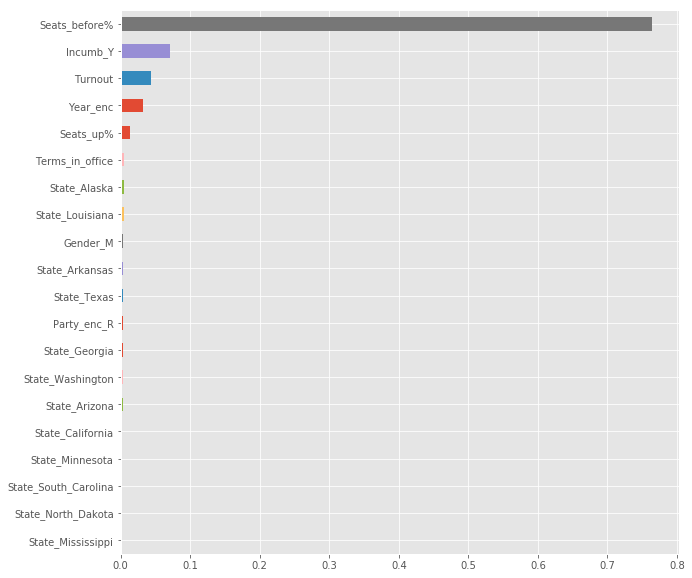

In [28]:
## Plotting importances pt. 1
gend_imps = dlf.plot_importance(rf_reg_final_gend, X_gend_train, top_n=20)

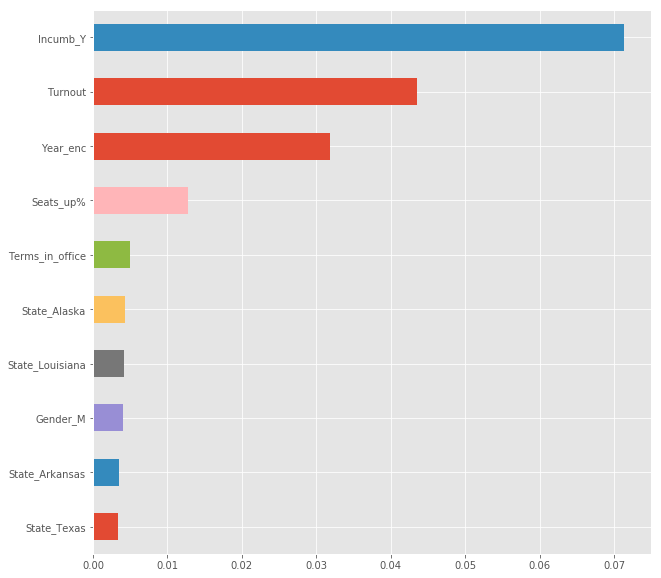

In [29]:
## Plotting importances pt. 2
gend_imps.drop(index='Seats_before%').sort_values(ascending=True).tail(10).plot(kind='barh',figsize=(10,10));

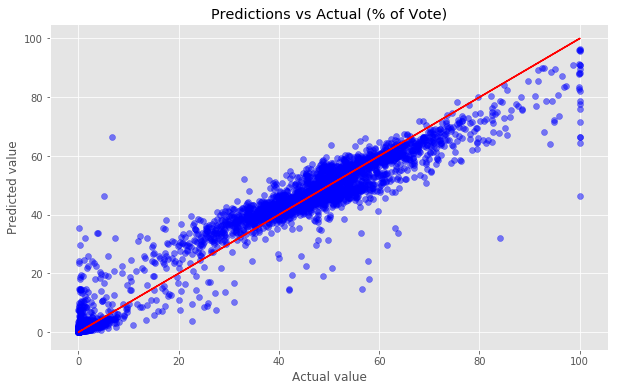

In [30]:
## Setting figsize
fig, ax = plt.subplots(figsize=(10,6))

## Plotting + formatting
ax.plot(y_gend_train, y_gend_train, c='r')
ax.set(title='Predictions vs Actual (% of Vote)', xlabel='Actual value', ylabel='Predicted value')
ax.scatter(y_gend_train, y_hat_gend_train, c='b', alpha=0.5);

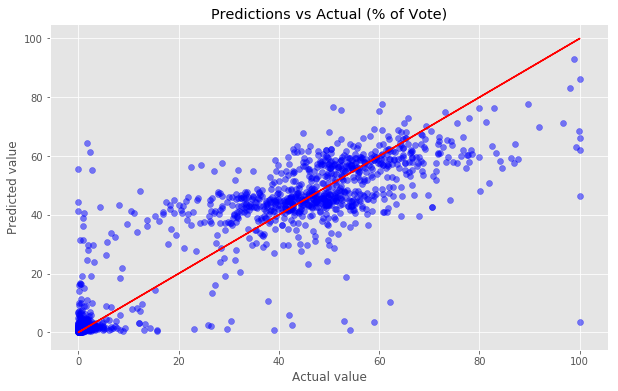

In [31]:
## Setting figsize
fig, ax = plt.subplots(figsize=(10,6))

## Plotting + formatting
ax.plot(y_gend_test, y_gend_test, c='r')
ax.set(title='Predictions vs Actual (% of Vote)', xlabel='Actual value', ylabel='Predicted value')
ax.scatter(y_gend_test, y_hat_gend_test, c='b', alpha=0.5);

## Conclusions & Recommendations

#### Conclusions

My final model was able to achieve an approximate RMSE of 10.86% (of votes) and R-squared of 82.92%. Although I do think there still may be some extra performance to be squeezed out of this model, I am satisfied with these results. 

The training results from this model has uncovered some good insights that may be of use to any participating in this process and/or learning from it. I will be interpreting these results from a perspective of someone in party leadership looking to use this in their own election.

Some insights include:
* Experience is everything (Incumbency brings rewards)
* Majority rules (Party presence across nation)
* When is more important than where
* Voter participation is key
* Party selection is important for non-incumbents


#### Recommendations

The first thing I would recommend to any perspective candidate for a U.S. Senate seat would be to decide whether or not they want to join in the one of the two major parties (Democratic or Republican). My results show that being an incumbent senator is the most important thing a candidate can *personally* bring into an election. If they are not an incumbent, the information I found in my EDA shows that without this distinguishment, on average you would receive 50% less of the total vote than if you did. 

Once a party alignment has been decided, I would suggest they look into their parties' respective GOTV (Get Out The Vote) strategies. This is because the importance of voter turnout in my model. Getting more people to vote seems like an obvious recommendation, but making sure that people who *say* they will vote for you *actually* do can be tougher than it seems. This is where the name recognition that comes with incumbency will help.

Lastly, I would recommend that the candidate remain extremely plugged into the current state of the environment that they are running in. The amount of seats the party held the prior election cycle and the year were the most and fourth important features in my model, respectively. This indicates that the overall political climate can weigh heavily on the success of any given candidate, meaning that one needs to be able to 'ride the wave' if necessary or 'dig in their heels' alternatively. In both situations (hopefully) in accordance with their party's messaging.

## Next..

Simply put, I would like more data to consider. I do understand that it will take years between election cycles to get the results for the future predictions, but in the meantime I would like to collect as much information on the past candidates as possible. 

My next targets would be age, gender, birthplace, number of attempts at office, military service, and potentially more. 

Otherwise, my next steps would be applying this model in a way that can predict a winner of a particular race given a number of candidates, which could be further extrapolated to help gauge the outlook of the next U.S. Senate between cycles.